In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
def generate_3d_dipole_kernel(data_shape, voxel_size, b_vec):
    fov = np.array(data_shape) * np.array(voxel_size)

    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                             np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                             np.arange(-data_shape[2] // 2, data_shape[2] // 2))

    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]

    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    
    kernel = (1 / 3 - d2)

    return kernel

def forward_convolution(chi_sample):
    scaling = np.sqrt(chi_sample.size)
    chi_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(chi_sample))) / scaling
    
    chi_fft_t_kernel = chi_fft * dipole_kernel
   
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(chi_fft_t_kernel)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase

def dipole_inversion(y):
    scaling = np.sqrt(y.size)
    tp0 = y/scaling
    xtk = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(tp0)))
    x0 = xtk/dipole_kernel
    x0[np.isnan(x0)==1]=0
    x0[np.isinf(x0)==1]=0
    x = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(x0)))*scaling)
    return x

def dipole_inversion_tkd(y,th):
    scaling = np.sqrt(y.size)
    tp0 = y/scaling
    xtk = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(tp0)))
    x0 = xtk/dipole_kernel
    x0[np.isnan(x0)==1]=0
    x0[np.isinf(x0)==1]=0
    x0[np.abs(dipole_kernel)<th]=np.sign(dipole_kernel)*th
    x = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(x0)))*scaling)
    return x

In [15]:
chi0 = nib.load('/home/oem/hufsbaby/ycm/qsm/files/Chi_ptm.nii.gz').get_fdata()
dipole_kernel = generate_3d_dipole_kernel(chi0.shape, voxel_size=1., b_vec=[0, 0, 1])

In [4]:

chi = np.zeros_like(chi0)
chi[chi0==1] = 0.05
chi[chi0==2] = 0.2
chi[chi0==3] = -0.2

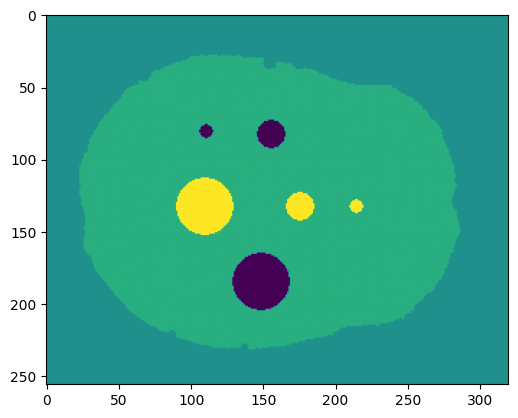

In [24]:
plt.imshow(chi[:,:,160])
plt.show()

In [25]:
# tissue phase generation from chi map (forward calculation)
tp = forward_convolution(chi)


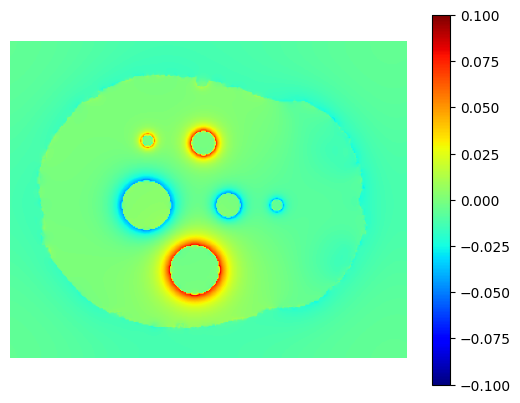

In [7]:
SN = 160
plt.imshow(tp[:,:,SN],cmap='jet',vmin=-.1, vmax=.1)
plt.colorbar()
plt.axis('off')
plt.show()

In [8]:
# QSM (inverse problem)
qsm = dipole_inversion(tp)

/tmp/ipykernel_3390100/4110157878.py:33: RuntimeWarning: divide by zero encountered in divide
  x0 = xtk/dipole_kernel
/tmp/ipykernel_3390100/4110157878.py:33: RuntimeWarning: invalid value encountered in divide
  x0 = xtk/dipole_kernel


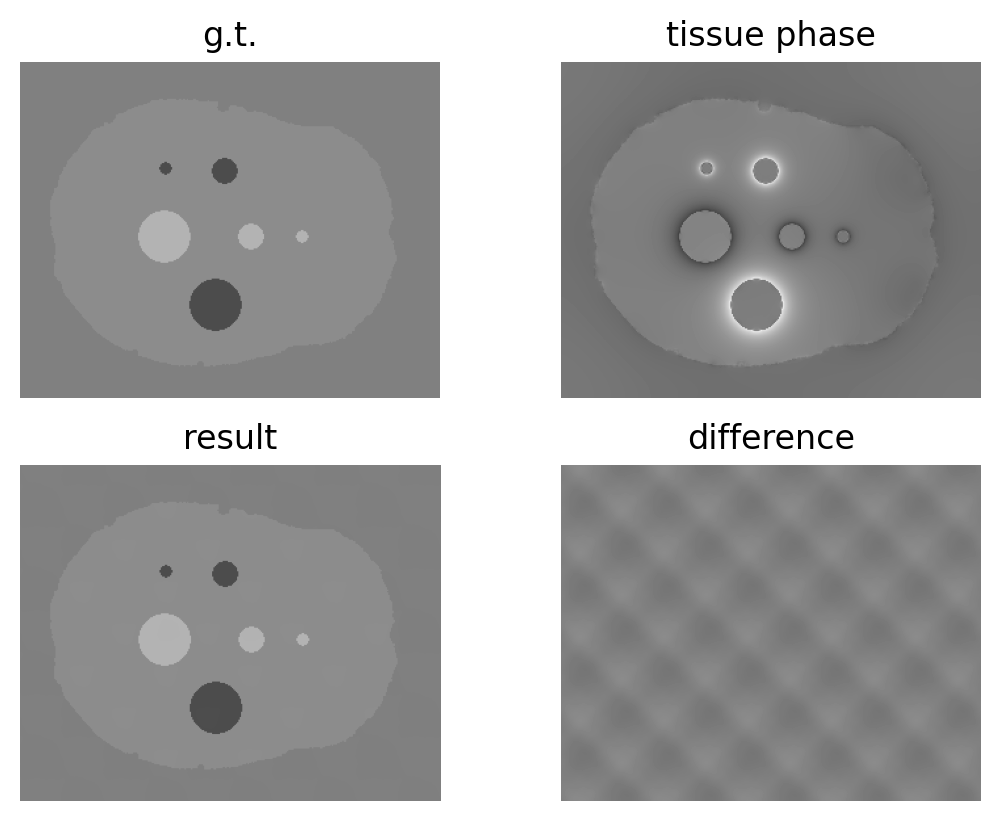

In [9]:
SN = 160
plt.figure(dpi=200)
plt.subplot(221)
plt.imshow(chi[:,:,SN],vmin=-.5,vmax=.5,cmap='gray')
plt.axis('off')
plt.title('g.t.')
plt.subplot(222)
plt.imshow(tp[:,:,SN],cmap='gray',vmin=-.1,vmax=.1)
plt.axis('off')
plt.title('tissue phase')
plt.subplot(223)
plt.imshow(qsm[:,:,SN],vmin=-.5,vmax=.5,cmap='gray')
plt.axis('off')
plt.title('result')
plt.subplot(224)
plt.imshow(qsm[:,:,SN]-chi[:,:,SN],vmin=-.015,vmax=.015,cmap='gray')
plt.axis('off')
plt.title('difference')
plt.show()

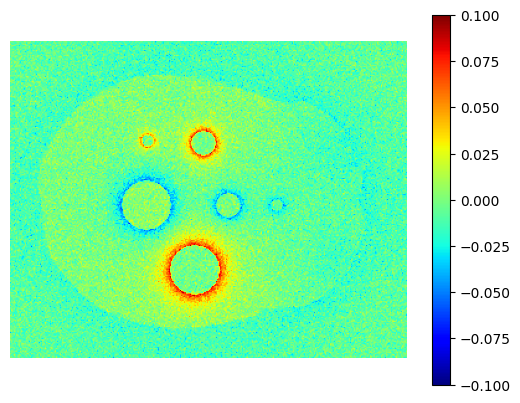

In [10]:
SN = 160
tp_n = tp + .01*np.random.randn(tp.shape[0],tp.shape[1],tp.shape[2])
plt.imshow(tp_n[:,:,SN],cmap='jet',vmin=-.1, vmax=.1)
plt.colorbar()
plt.axis('off')
plt.show()

In [11]:
# QSM (inverse problem)
qsm_n = dipole_inversion(tp_n)

/tmp/ipykernel_3390100/4110157878.py:33: RuntimeWarning: divide by zero encountered in divide
  x0 = xtk/dipole_kernel


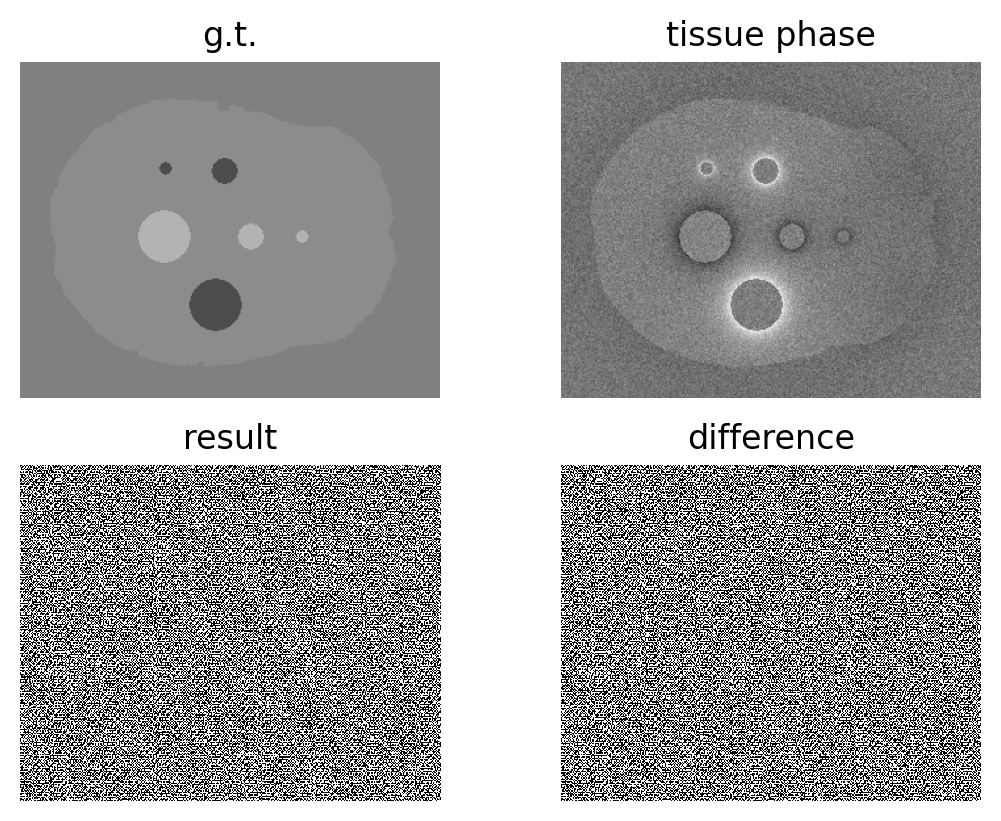

In [12]:
SN = 160
plt.figure(dpi=200)
plt.subplot(221)
plt.imshow(chi[:,:,SN],vmin=-.5,vmax=.5,cmap='gray')
plt.axis('off')
plt.title('g.t.')
plt.subplot(222)
plt.imshow(tp_n[:,:,SN],cmap='gray',vmin=-.1,vmax=.1)
plt.axis('off')
plt.title('tissue phase')
plt.subplot(223)
plt.imshow(qsm_n[:,:,SN],vmin=-.5,vmax=.5,cmap='gray')
plt.axis('off')
plt.title('result')
plt.subplot(224)
plt.imshow(qsm_n[:,:,SN]-chi[:,:,SN],vmin=-.015,vmax=.015,cmap='gray')
plt.axis('off')
plt.title('difference')
plt.show()